In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['vgg19', 'imet-2019-fgvc6']


In [2]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import fbeta_score
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Dropout
from keras import optimizers, applications
from keras import backend as K 

Using TensorFlow backend.


In [3]:
train_df = pd.read_csv("../input/imet-2019-fgvc6/train.csv")
train_df["attribute_ids"]=train_df["attribute_ids"].apply(lambda x:x.split(" "))
train_df["id"]=train_df["id"].apply(lambda x:x+".png")
print(train_df.shape)
train_df.head()

(109237, 2)


,id,attribute_ids
0,1000483014d91860.png,"[147, 616, 813]"
1,1000fe2e667721fe.png,"[51, 616, 734, 813]"
2,1001614cb89646ee.png,[776]
3,10041eb49b297c08.png,"[51, 671, 698, 813, 1092]"
4,100501c227f8beea.png,"[13, 404, 492, 903, 1093]"


In [4]:
label_df = pd.read_csv("../input/imet-2019-fgvc6/labels.csv")
print(label_df.shape)
label_df.head()

(1103, 2)


,attribute_id,attribute_name
0,0,culture::abruzzi
1,1,culture::achaemenid
2,2,culture::aegean
3,3,culture::afghan
4,4,culture::after british


In [5]:
cultures = [x for x in label_df.attribute_name.values if x.startswith("culture")]
tags = [x for x in label_df.attribute_name.values if x.startswith("tag")]
len(cultures)+1, len(tags)+1

(399, 706)

In [6]:
labels = list(map(str, range(1103)))

In [7]:
batch_size = 64
img_size = 256
epochs = 5

In [8]:
train_datagen=ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.25,
    horizontal_flip = True,    
    zoom_range = 0.3,
    width_shift_range = 0.3,
    height_shift_range=0.3
    )

In [9]:
train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="../input/imet-2019-fgvc6/train",
    x_col="id",
    y_col="attribute_ids",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",
    classes=labels,
    target_size=(img_size , img_size ),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="../input/imet-2019-fgvc6/train",
    x_col="id",
    y_col="attribute_ids",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",
    classes=labels,
    target_size=(img_size , img_size ),
    subset='validation')

Found 81928 images belonging to 1103 classes.
Found 27309 images belonging to 1103 classes.


In [10]:
model = applications.VGG19(weights = None, include_top=False, input_shape = (img_size, img_size, 3))
model.load_weights("../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5")

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
for layers in model.layers:
    layers.trainable = False

In [12]:
gamma = 2.0
epsilon = K.epsilon()
def focal_loss(y_true, y_pred):
    pt = y_pred * y_true + (1-y_pred) * (1-y_true)
    pt = K.clip(pt, epsilon, 1-epsilon)
    CE = -K.log(pt)
    FL = K.pow(1-pt, gamma) * CE
    loss = K.sum(FL, axis=1)
    return loss

In [13]:
# def f2_score(y_true, y_pred):
#     beta = 2
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=1)
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=1)
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=1)
    
#     precision = true_positives / (predicted_positives + K.epsilon())
#     recall = true_positives / (possible_positives + K.epsilon())
    
#     return K.mean(((1+beta**2)*precision*recall) / ((beta**2)*precision+recall+K.epsilon()))

In [14]:
def f2_score(y_true, y_pred, threshold=0.1, beta=2):
    tp = tp_score(y_true, y_pred, threshold)
    fp = fp_score(y_true, y_pred, threshold)
    fn = fn_score(y_true, y_pred, threshold)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return (1+beta**2) * ((precision * recall) / ((beta**2)*precision + recall))


def tp_score(y_true, y_pred, threshold=0.1):
    tp_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(y_true)), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.greater(y_pred, K.constant(threshold)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=1
    )
    tp = K.sum(K.cast(K.all(tp_3d, axis=1), 'int32'))
    return tp


def fp_score(y_true, y_pred, threshold=0.1):
    fp_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(K.abs(y_true - K.ones_like(y_true)))), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.greater(y_pred, K.constant(threshold)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=-1
    )
    fp = K.sum(K.cast(K.all(fp_3d, axis=1), 'int32'))
    return fp


def fn_score(y_true, y_pred, threshold=0.1):
    fn_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(y_true)), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.abs(K.cast(K.greater(y_pred, K.constant(threshold)), 'float') - K.ones_like(y_pred)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=1
    )
    fn = K.sum(K.cast(K.all(fn_3d, axis=1), 'int32'))
    return fn


def precision_score(y_true, y_pred, threshold=0.1):
    tp = tp_score(y_true, y_pred, threshold)
    fp = fp_score(y_true, y_pred, threshold)
    return tp / (tp + fp)


def recall_score(y_true, y_pred, threshold=0.1):
    tp = tp_score(y_true, y_pred, threshold)
    fn = fn_score(y_true, y_pred, threshold)
    return tp / (tp + fn)

In [15]:
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1103, activation="sigmoid")(x)
model_final = Model(input = model.input, output = predictions)
model_final.compile(optimizers.rmsprop(lr=0.001, decay=1e-6),loss=focal_loss,metrics=[f2_score])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [16]:
#model_final.summary()

In [17]:
history = model_final.fit_generator(generator=train_generator,                   
                                    steps_per_epoch=len(train_generator),
                                    validation_data=valid_generator,                    
                                    validation_steps=len(valid_generator),
                                    epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
1281/1281 [==============================] - 2317s 2s/step - loss: 11.7129 - f2_score: 0.0691 - val_loss: 5.5937 - val_f2_score: 0.0507
Epoch 2/5
1281/1281 [==============================] - 2293s 2s/step - loss: 7.9149 - f2_score: 0.0403 - val_loss: 5.5404 - val_f2_score: 0.0310
Epoch 3/5
1281/1281 [==============================] - 2276s 2s/step - loss: 5.5870 - f2_score: 0.0334 - val_loss: 5.0320 - val_f2_score: 0.0511
Epoch 4/5
1281/1281 [==============================] - 2289s 2s/step - loss: 5.0118 - f2_score: 0.0643 - val_loss: 4.9881 - val_f2_score: 0.0711
Epoch 5/5
1281/1281 [==============================] - 2283s 2s/step - loss: 5.0404 - f2_score: 0.0737 - val_loss: 5.0412 - val_f2_score: 0.0747


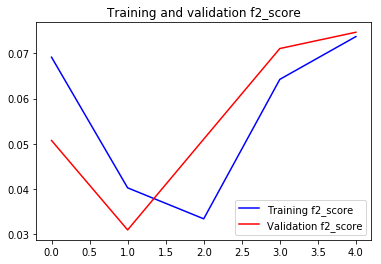

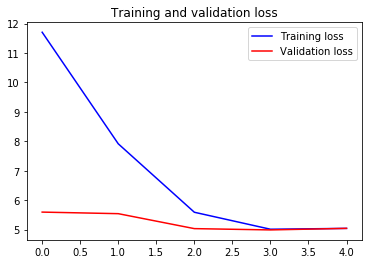

In [23]:
import matplotlib.pyplot as plt
f2_score = history.history['f2_score']
val_f2_score = history.history['val_f2_score']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epoch = range(len(f2_score))
 
plt.plot(epoch, f2_score, 'b', label='Training f2_score')
plt.plot(epoch, val_f2_score, 'r', label='Validation f2_score')
plt.title('Training and validation f2_score')
plt.legend()
 
plt.figure()
 
plt.plot(epoch, loss, 'b', label='Training loss')
plt.plot(epoch, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [24]:
model.save("VGG19_facol_loss.h5")

In [25]:
ls

VGG19_facol_loss.h5  __notebook_source__.ipynb
